In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn

```bash
!pip install tensorflow tensorflow_datasets
```

# Neural Network on MNIST dataset

Let's revisit the problem of recognizing handwritten digits from the MNIST dataset.  We'll make use of the data currated in `tensorflow_datasets`, which also has lots of convenient methods for splits data, batching, etc.

In [2]:
train_ds = tfds.load('mnist', split='train')
test_ds = tfds.load('mnist', split='test')

In [3]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

These data objects are very efficient with lots convenient methods, but they are a little cumbersome to interact with for simple tasks like plotting an example.

(28, 28, 1)


2023-05-23 21:10:26.167818: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


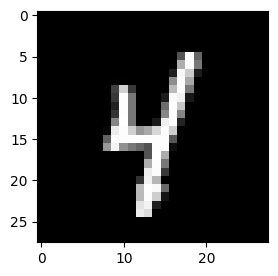

In [4]:
f = plt.figure(figsize=(15,3))

for ex in train_ds.as_numpy_iterator():
    print(ex['image'].shape)
    plt.imshow(ex['image'], cmap='gray')
    break

In [5]:
for example in train_ds.as_numpy_iterator():
    print(example['image'].max())
    break

255


2023-05-23 21:10:26.240652: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Notice that the pixel values imported as an integer array that saturates at $255$.  Let's turn the data into floats $\in [0, 1]$.

In [6]:
train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                        tf.float32) / 255.,
                                        'label': sample['label']}) # normalize train set
test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                        tf.float32) / 255.,
                                    'label': sample['label']}) # normalize test set

In [7]:
tf.random.set_seed(0) # ensure dataset shuffling

We're going to batch the data, and also choose random subsets.  We don't need to train on the whole set in this case.

In [8]:
num_epochs = 10
batch_size = 32

# shuffle data by allocating a buffer of 1024 to randomly draw examples from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
test_ds = test_ds.shuffle(1024)

# group into batches of 32, skip incomplete batch, prefetch next sample to speed up
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

Now let's build a neural network.  Let's build a network with two hidden layers with 100 nodes each.  We'll use the *ReLU* activation function (see, e.g., [here](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) for lots more details).

In [9]:
n_classes = 10

class DenseNN(nn.Module):
  """A simple model with densely connected layers."""

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))   # flatten
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=n_classes)(x)
    return x

We can use `.tabulate()` to get a summary of the model.  Remember that we haven't specified the shape of `x` in the model above, meaning it doesn't actually know the date volume shapes (or number of parameters) unless we give it data with the right shape.

In [10]:
import jax
import jax.numpy as jnp  # JAX NumPy

dummy_input = jnp.ones((1, 28, 28, 1))

dnn = DenseNN()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                                DenseNN Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs             ┃ outputs        ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ DenseNN │ float32[1,28,28,1] │ float32[1,10]  │                    │
├─────────┼─────────┼────────────────────┼────────────────┼────────────────────┤
│ Dense_0 │ Dense   │ float32[1,784]     │ float32[1,100] │ bias: float32[100] │
│         │         │                    │                │ kernel:            │
│         │         │                    │                │ float32[784,100]   │
│         │         │                    │                │                    │
│         │         │                    │                │ 78,500 (314.0 KB)  │
├─────────┼─────────┼────────────────────┼────────────────┼────────────────────┤
│ Dense_1 │ Dense   │ float

We need to do a little legwork to setup some object for tracking training metrics (e.g., loss, accuracy).  We'll use the `clu` companion library to make our lives (a little) easier.

```bash
!pip install clu
```

In [11]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [12]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

Next we'll create a function that will initial our training state for us.

In [13]:
def create_train_state(model, rng, learning_rate, momentum):
    params = model.init(rng, dummy_input)['params']
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

Finally, let's define functions that will perform a training step (i.e., update parameters based on a batch of training data), and compute training metrics.

In [14]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [15]:
@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

Let's create a training state and prepare to train.

In [16]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01
momentum = 0.9

state = create_train_state(dnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

We'll track metrics along the way...

In [17]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [18]:
train_ds.cardinality().numpy()

18750

In [19]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
num_steps_per_epoch

1875

In [20]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.2864380478858948, accuracy: 91.6066665649414
test epoch: 1, loss: 0.1450791358947754, accuracy: 95.53285217285156
train epoch: 2, loss: 0.11026730388402939, accuracy: 96.72000122070312
test epoch: 2, loss: 0.10467476397752762, accuracy: 96.63461303710938
train epoch: 3, loss: 0.07560433447360992, accuracy: 97.78500366210938
test epoch: 3, loss: 0.09052639454603195, accuracy: 97.15544891357422
train epoch: 4, loss: 0.056627608835697174, accuracy: 98.33499908447266
test epoch: 4, loss: 0.08805624395608902, accuracy: 97.29566955566406
train epoch: 5, loss: 0.04632475972175598, accuracy: 98.6433334350586
test epoch: 5, loss: 0.07748545706272125, accuracy: 97.59615325927734
train epoch: 6, loss: 0.03552898392081261, accuracy: 99.01000213623047
test epoch: 6, loss: 0.07611264288425446, accuracy: 97.73637390136719
train epoch: 7, loss: 0.028327208012342453, accuracy: 99.23333740234375
test epoch: 7, loss: 0.0742904469370842, accuracy: 97.69631958007812
train epoch: 8, 

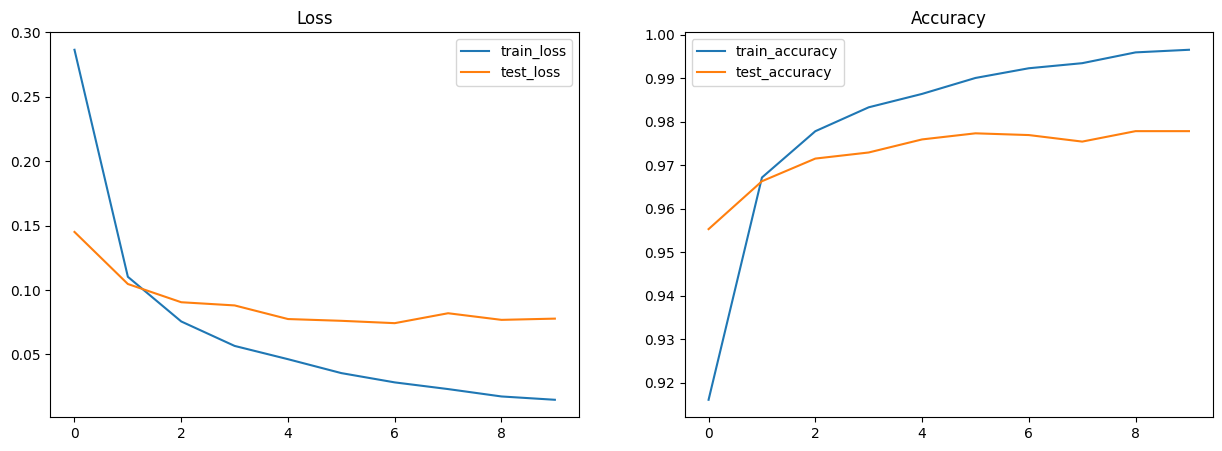

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

Let's see how are model does at predicting specific examples from the test set.

In [22]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

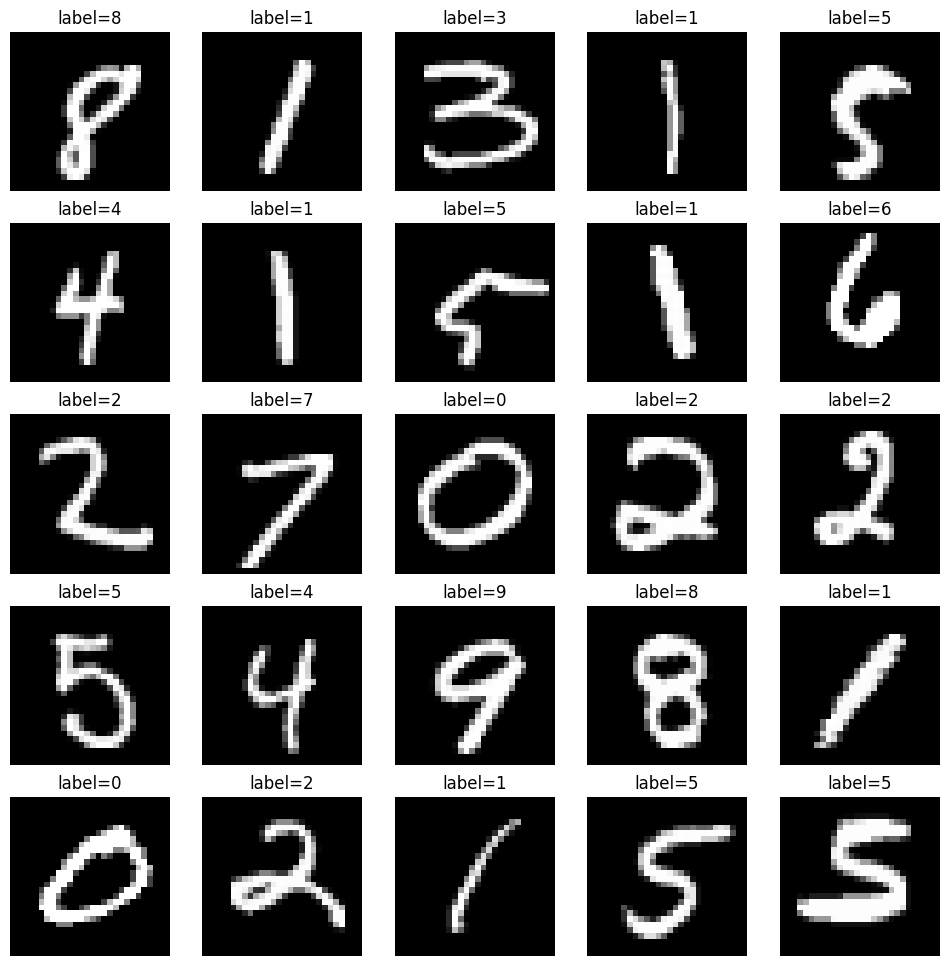

In [23]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

What if we manipulate the data a bit.  Is it easily confused?

In [24]:
new_test_ds = test_ds.map(lambda sample: {'image': tf.roll(sample['image'], 3, 2),
                                          'label': sample['label']})

In [25]:
new_test_ds

<_MapDataset element_spec={'image': TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(32,), dtype=tf.int64, name=None)}>

In [26]:
new_test_batch = new_test_ds.as_numpy_iterator().next()
new_pred = pred_step(state, new_test_batch)

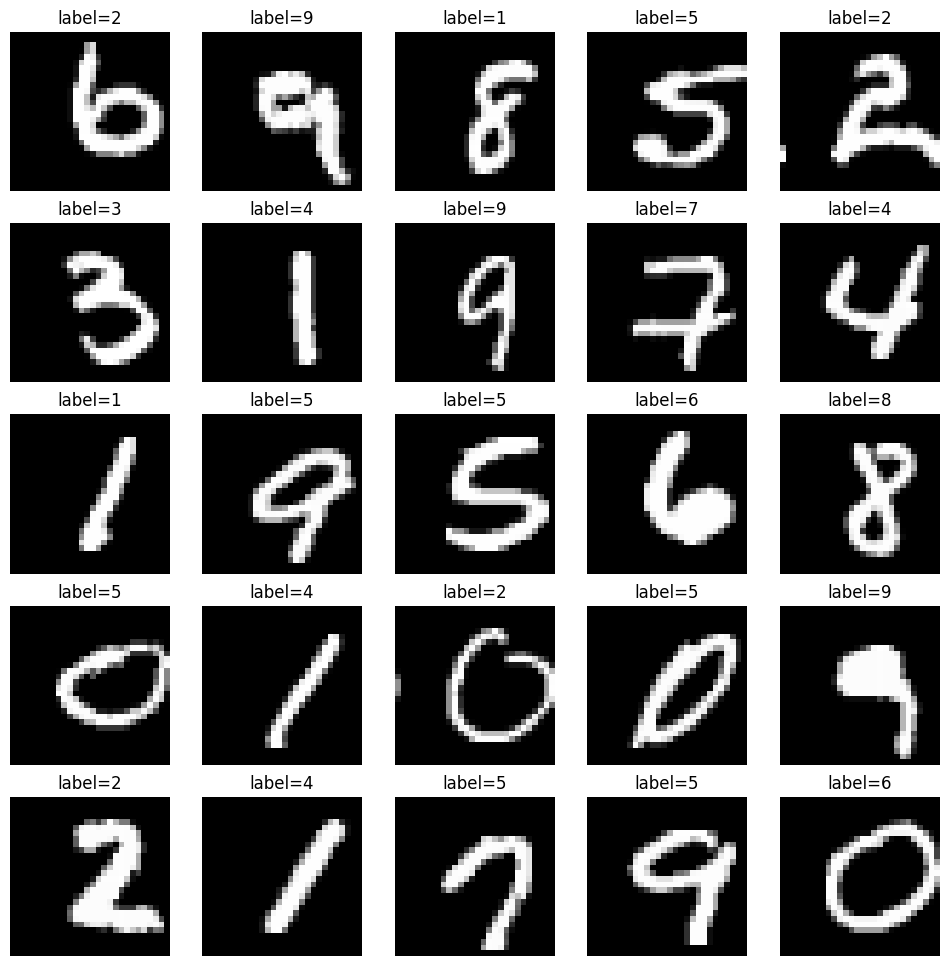

In [27]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(new_test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={new_pred[i]}")
    ax.axis('off')